In [1]:
# gettting the range of the intensity and the number of pepetides
import pandas as pd
import os
from pathlib import Path
import numpy as np
direcroy_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT'
phoshpho_scores_path = Path(direcroy_path)/Path('protein_results/protein_scores.tsv')
plot_saving_dir = "/media/kusterlab/internal_projects/active/TOPAS/Publications/Manuscript_MTB/Invests for Paper_Amir/Correlation_Transcriptome vs Proteome"
patietns_meta_data = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_MTBs_Evaluation/Metadata_Papercohort_230727.xlsx'
# intensity files
PREPROCESSED_FP_INTENSITY = 'preprocessed_fp.csv'


REGEX = r'(^\S+-.+-\S)|(Reporter intensity corrected)|(^P\d{6}$)'
Z_SCORES_PATH = 'full_proteome_measures_z.tsv'
Z_SCORE_REGEX = r'(^\S+-.+-\S)|(Reporter intensity corrected)|(^P\d{6}$) Z-score'


def unnest_proteingroups(df:pd.DataFrame) -> pd.DataFrame:
    """
    Unnest the protein_groups A;B as two separate rows with the same values
    the protein groups are the index of the the pandas dataframe df
    """
    temp_df = df
    temp_df['index'] = temp_df.index.str.split(';')
    temp_df = temp_df.explode('index')
    temp_df = temp_df.set_index('index')
    return temp_df


def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def setdiff(lst1,lst2):
    return(list(set(lst1) - set(lst2)))


def get_correlation_perpatient(patient:str,df1,df2):
    ans = None
    try:
        df1 = pd.DataFrame(df1.loc[:,patient])
        df2 = pd.DataFrame(df2.loc[:,patient])
        all_df= pd.concat([df1,df2],axis=1)
        all_df = all_df.dropna()
        ans = all_df.corr().iloc[0,1]
    except:
        print(f'{patient} lead to error we put NA')
        pass
    return ans,len(all_df)


        



In [2]:
meta_df = pd.read_excel(patietns_meta_data)
Rna_failed = meta_df['Sample name'][meta_df['RNA QC issue']=='x'].unique().tolist()


# Correlation between the protein and phoshpho scores per  patient


In [3]:
#  full proteome_z_scores
Z_SCORES_df_proteome = pd.read_csv(Path(direcroy_path)/Path(Z_SCORES_PATH),sep='\t')
Z_SCORES_df_proteome = Z_SCORES_df_proteome.set_index('Gene names')
Z_SCORES_df_proteome = Z_SCORES_df_proteome.filter(regex=REGEX)
# there is no protein grouping at transcriptome level we unnest the protein groups also for protein data
#Z_SCORES_df_proteome = unnest_proteingroups(Z_SCORES_df_proteome)
Z_SCORES_df_proteome.columns = Z_SCORES_df_proteome.columns.str.replace('zscore_','')


phospho_z_scores_df = pd.read_csv(phoshpho_scores_path,sep='\t')
phospho_z_scores_df = phospho_z_scores_df.set_index('Gene names')
#phospho_z_scores_df = unnest_proteingroups(phospho_z_scores_df)
#transcripts_z_scores = transcripts_z_scores.set_index('genes')

patients_list = intersection(phospho_z_scores_df.columns, Z_SCORES_df_proteome.columns)
proteins_list = intersection(phospho_z_scores_df.index, Z_SCORES_df_proteome.index)


Z_SCORES_df_proteome = Z_SCORES_df_proteome.loc[proteins_list,patients_list]
phospho_z_scores_df = phospho_z_scores_df.loc[proteins_list,patients_list]
correlation_df = pd.DataFrame(patients_list,columns=['patients'])
correlation_df['correlation'] = None
correlation_df['num_proteins'] = None


for i in range(len(correlation_df)):
    protein_correlaiton, num_proteins = get_correlation_perpatient(correlation_df['patients'][i],Z_SCORES_df_proteome,phospho_z_scores_df)
    correlation_df['correlation'][i] = protein_correlaiton
    correlation_df['num_proteins'][i] = num_proteins


correlation_df['rna_failed'] = None
correlation_df['rna_failed'][correlation_df['patients'].isin(Rna_failed)]='x'
new_cor_df = correlation_df[correlation_df['rna_failed']=='x']

# Histogram

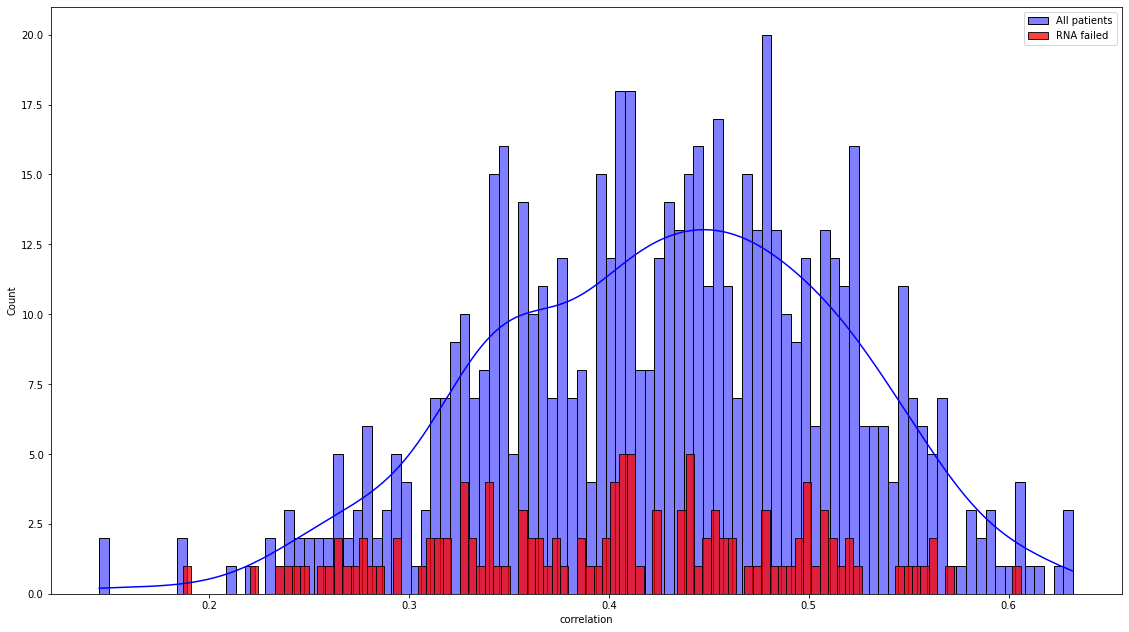

In [35]:

import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(19.20,10.80))

correlation_df = correlation_df.dropna(subset='correlation')


sns.histplot(data=correlation_df, x="correlation",label="All patients", kde=True, color="blue",bins=100)  # for all patients
sns.histplot(data=new_cor_df, x="correlation",label="RNA failed",  color="red",bins=100)  # for all patients
#plt.axvline(2.8, 0,0.17)
plt.legend() 
#plt.show()
plt.savefig(f'{plot_saving_dir}/patient_based_correlation_between_phoshphoscore_FP.svg',dpi=300)



In [37]:
correlation_df.to_excel('~/Desktop/correlation_all_proteins_phoshpho_scores.xlsx')